# Welcome to the Biotek Package

The Biotek package of `murraylab_tools` is designed to make your life easier when analyzing Biotek time series data. Specifically, murraylab_tools.Biotek converts Biotek data to tidy format for easy analysis with Pandas and easy plotting with Seaborn. The package also contains a few convenience functions for some of the things you're likely to do with TX-TL time series data, currently including:
* Background subtraction.
* Endpoint summarization.
* Measurement average over any contiguous window.
* Spline fitting to measurement curves.
* Smoothed derivative calculation.
* OD normalization (or any other time-varying normalization)

### Data Tidying

Converting from Biotek output to a tidy, Pandas-readable format is simple:

In [1]:
import murraylab_tools.biotek as mt_biotek
import os

# Note that the input file must be from excel output of a Biotek experiment,
# saved in CSV format. 
data_filename = os.path.join("biotek_examples", "RFP_GFP_traces.csv")
mt_biotek.tidy_biotek_data(data_filename, volume = 5)

A tidified version of the data will be created with the same name and location as the original time trace file, with "_tidy" appended to the end of the name (pre-suffix).

Usually you will also want access to some meta-data on your experiment -- most importantly, what plasmids were put in each well, in what concentration. You can add this metadata in the form of a supplementary spreadsheet. The first column of the supplementary spreadsheet is assumed to contain a well number (e.g., "D4" or "A08"). Every other column contains some kind of metadata keyed to that well number, with a name of that metadata given in a header row. You can write that supplementary data file yourself in Excel or notepad. 

Here is an example of how to write a supplementary file programmatically. This experiment contains three replicated 2D titrations of a GFP plasmid on one axis (at concentrations of 0.25, 0.5, 1, and 2 nM) and an RFP plasmid on the other axis (at concentrations of 0.5, 1, 2, and 4 nM).

In [2]:
import csv, string

rfp_concs = [0.44, 0.88, 2.20, 3.97]
gfp_concs = [0.24, 0.49, 0.98, 2.01]
replicates = [1,2,3]

supplementary_filename = os.path.join("biotek_examples", "RFP_GFP_supplementary.csv")
with open(supplementary_filename, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Well', 'RFP Plasmid (nM)', 'GFP Plasmid (nM)', 'Replicate'])
    for row in range(4):
        for col in range(4):
            well_names = [string.ascii_uppercase[row] + "%d" % (col+6),
                          string.ascii_uppercase[row] + "%d" % (col+11),
                          string.ascii_uppercase[row+6] + "%d" % (col+1)]
            for rep in replicates:
                writer.writerow([well_names[rep-1], rfp_concs[row], gfp_concs[col], 
                                  rep])
    # Also include metadata for three negative control wells.
    writer.writerow(["E10", 0, 0, 1])
    writer.writerow(["E15", 0, 0, 2])
    writer.writerow(["K5", 0, 0, 3])
                

and to use that supplementary data:

In [3]:
mt_biotek.tidy_biotek_data(data_filename, supplementary_filename, volume = 5)

Now we can easily read our Biotek data using Pandas:

In [4]:
import pandas as pd

tidy_filename = os.path.join("biotek_examples", "RFP_GFP_traces_tidy.csv")
df = pd.read_csv(tidy_filename)

Let's peek at the data in its tidy format:

In [5]:
df.head()

,Channel,Gain,Time (sec),Time (hr),Well,AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate
0,RFP,100,0,0.0,A6,16,0.018946,580,580,0.44,0.24,1
1,RFP,100,0,0.0,A7,13,0.015394,580,580,0.44,0.49,1
2,RFP,100,0,0.0,A8,7,0.008289,580,580,0.44,0.98,1
3,RFP,100,0,0.0,A9,12,0.014210,580,580,0.44,2.01,1
4,RFP,100,0,0.0,A11,10,0.011841,580,580,0.44,0.24,2


As you can see, each row of tidy data describes one well's read value for a single channel and gain at a single time, along with some metadata about that well. 

Note that if you use data with OD600 measurements, you will get separate rows with those OD600 readings with channel "OD600", excitation 600, emission -1, gain -1, and the actual OD in the *uM* column. It's a bit of a dirty hack, but it works, as long as you know what to look for. For example:

In [6]:
data_filename = os.path.join("biotek_examples", "cell_data_traces.csv")
supplementary_filename = os.path.join("biotek_examples", "cell_data_supplemental.csv")
with open(supplementary_filename, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Well', 'Row', 'Column'])
    for row in range(8):
        for col in range(12):
            row_str = string.ascii_uppercase[row]
            col_str = str(col+1)
            well    = row_str + col_str
            writer.writerow([well, row_str, col_str])
mt_biotek.tidy_biotek_data(data_filename, supplementary_filename, volume = 500)
tidy_filename = os.path.join("biotek_examples", "cell_data_traces_tidy.csv")
cell_df = pd.read_csv(tidy_filename)
cell_df.head()

,Channel,Gain,Time (sec),Time (hr),Well,AFU,uM,Excitation,Emission,Row,Column
0,OD600,-1,145,0.040278,A1,0.091,0.091,600,-1,A,1
1,OD600,-1,145,0.040278,A2,0.107,0.107,600,-1,A,2
2,OD600,-1,145,0.040278,A3,0.120,0.120,600,-1,A,3
3,OD600,-1,145,0.040278,A4,0.127,0.127,600,-1,A,4
4,OD600,-1,145,0.040278,A5,0.110,0.110,600,-1,A,5


Now we can use Seaborn to start plotting data quickly and (relatively) easily. In this case, let's look at time traces of all three replicates of each combination of plasmids, first for GFP and then for RFP:

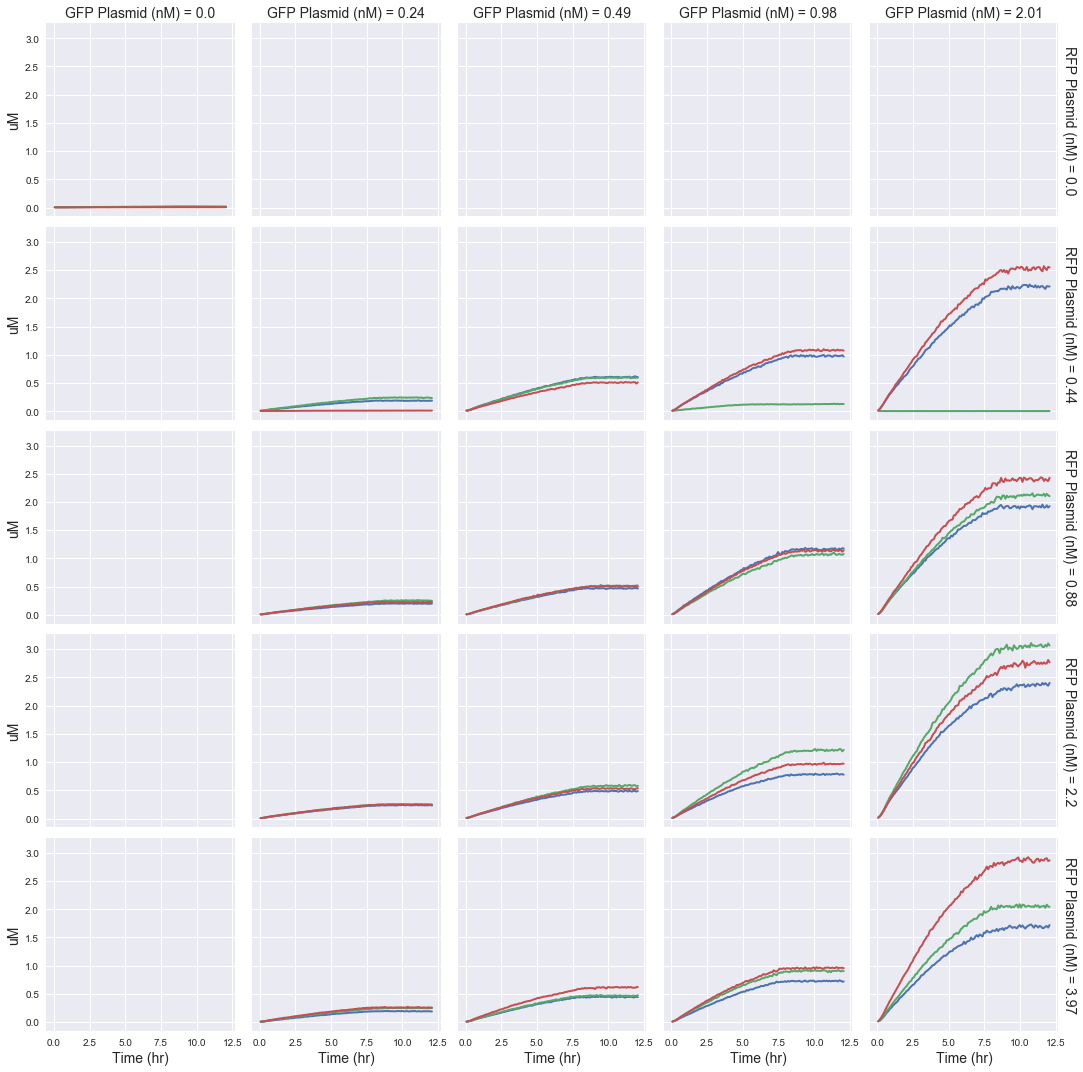

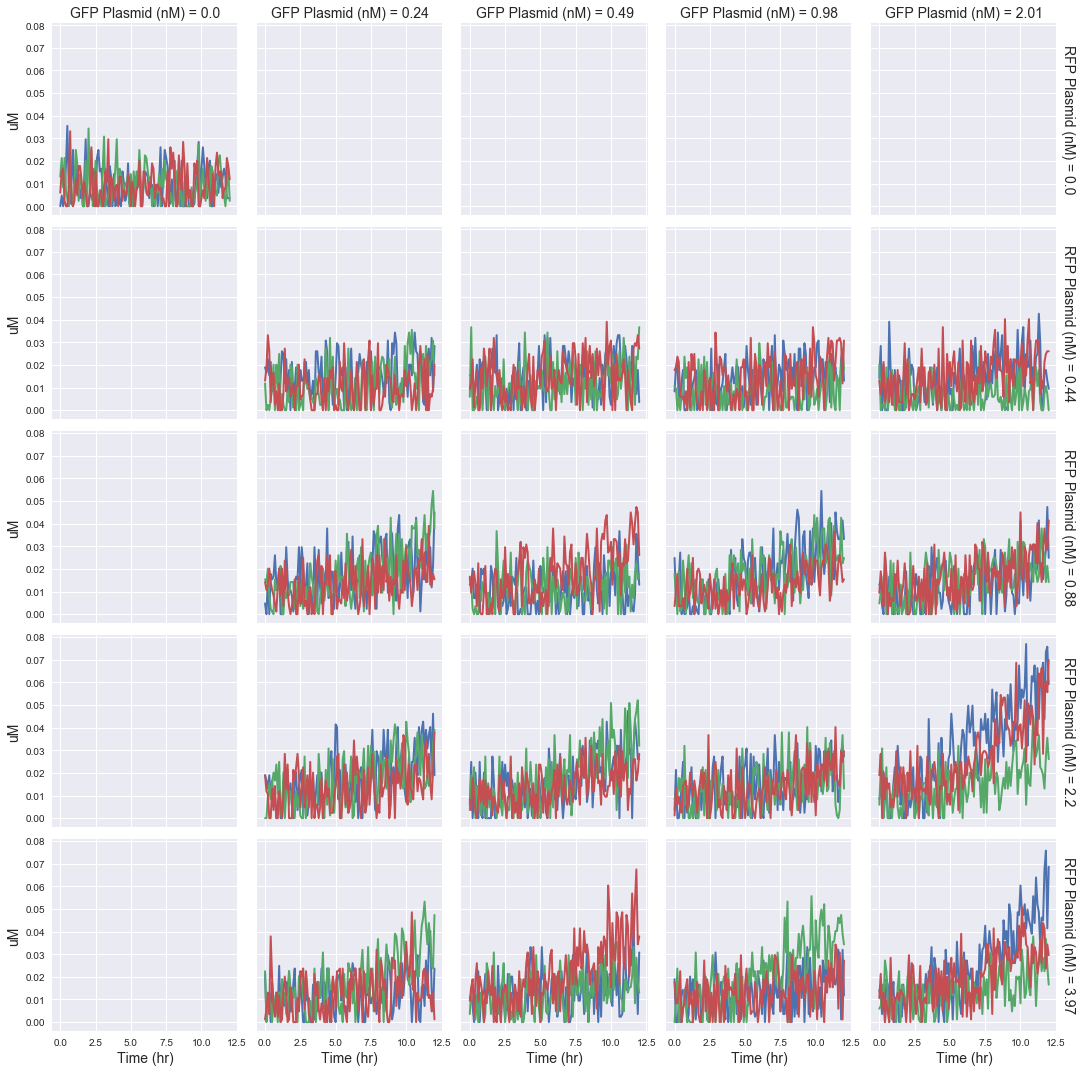

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

gfp_df = df[(df.Gain == 100) & (df.Channel == "GFP")]
rfp_df = df[(df.Gain == 100) & (df.Channel == "RFP")]
grid = sns.FacetGrid(gfp_df, col = "GFP Plasmid (nM)", row = "RFP Plasmid (nM)", 
                     hue = "Replicate", margin_titles = True)
grid.map(plt.plot, "Time (hr)", "uM")
grid.fig.tight_layout(w_pad=1)
plt.show()

plt.clf()
grid = sns.FacetGrid(rfp_df, col = "GFP Plasmid (nM)", row = "RFP Plasmid (nM)", 
                     hue = "Replicate", margin_titles = True)
grid.map(plt.plot, "Time (hr)", "uM")
grid.fig.tight_layout(w_pad=1)
plt.show()

### Automatic Unit Conversion

Note in the example above that the absolute concentrations of fluorescent proteins were automatically calculated in µM. The murraylab_tools.biotek package has a small database of known calibrations for our lab's Biotek's. It currently knows how to calibrate with GFP, Citrine, RFP, CFP, Venus, and Cherry, each at gains 61 and 100. The plate ID is pulled from the Biotek's output file. Fluorescent protein identities are pulled from channel names. If the name of a channel is sufficiently similar to one of the known fluorescent proteins, you will get automatic unit conversion. Here "sufficiently similar" means "contains as a substring". If you use a channel name with more than one known fluorescent protein name in it, you're not guaranteed any particular result, so don't do that.  

If you're feeling particularly meddlesome (or you want to add new calibration data to the package -- if so, please commit your changes to the repository!), you can see the calibration data near the top of the biotek.py file in the biotek subpackage of murraylab_tools. Calibration data is stored as a doubly-nested dictionary of the form

`calibration_data[channel][biotek_id][gain] = AFU/µM`.

If you don't use a channel containing the name of a calibrated substance, or you use a gain that hasn't been calibrated, then the µM concentration will be calculated as -1. 

# Convenience Functions

### Background Subtraction

Given a list of negative control wells, you can use the murraylab_tools.biotek package to subtract average background from your time series data:

In [8]:
negative_control_wells = ["E10", "E15", "K5"]
corrected_df = mt_biotek.background_subtract(df, negative_control_wells)
corrected_df.head()

,index,Channel,Gain,Time (sec),Time (hr),Well,AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate
0,0,RFP,100,0,0.0,A6,10.666667,0.012631,580,580,0.44,0.24,1
1,51,RFP,100,360,0.1,A6,2.333333,0.002763,580,580,0.44,0.24,1
2,102,RFP,100,720,0.2,A6,12.000000,0.014210,580,580,0.44,0.24,1
3,153,RFP,100,1080,0.3,A6,5.000000,0.005921,580,580,0.44,0.24,1
4,204,RFP,100,1440,0.4,A6,11.000000,0.013025,580,580,0.44,0.24,1


`background_subtract` returns a dataframe of corrected data, which can be analyzed just like the dataframes returned in the example above. 

### Endpoint Averaging

If you know your fluorescence data plateaus near the end of the run, you may want to quickly find the endpoint fluorescence of each well, averaged over the last few time points. You can quickly do this with the `endpoint_averages` function of the murraylab_tools.biotek package.

In [9]:
endpoint_df = mt_biotek.endpoint_averages(corrected_df)
endpoint_df.head()

,Channel,Gain,Well,index,Time (sec),Time (hr),AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate
0,GFP,61,A11,18236.5,41739,11.594167,170.933333,0.225357,488,488,0.44,0.24,2
1,GFP,61,A12,18237.5,41739,11.594167,443.033333,0.584091,488,488,0.44,0.49,2
2,GFP,61,A13,18238.5,41739,11.594167,85.733333,0.113030,488,488,0.44,0.98,2
3,GFP,61,A14,18239.5,41739,11.594167,-9.466667,-0.012481,488,488,0.44,2.01,2
4,GFP,61,A6,18232.5,41739,11.594167,132.433333,0.174599,488,488,0.44,0.24,1


Note that every numeric field has been averaged over the last five data points, so don't take the time column too seriously here. 

Now we can quickly plot endpoint averages for the two color channels:

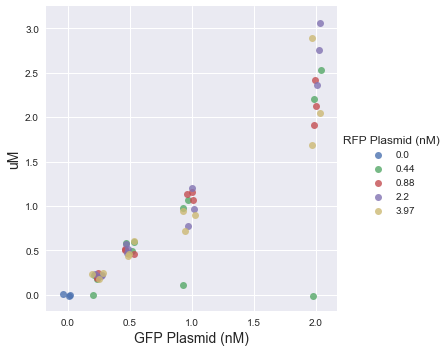

In [10]:
green_endpoints = endpoint_df[(endpoint_df.Channel == "GFP") & (endpoint_df.Gain == 61)]
sns.lmplot(data = green_endpoints, x = 'GFP Plasmid (nM)', 
              y = 'uM', hue = 'RFP Plasmid (nM)', fit_reg = False,
              x_jitter = 0.05)

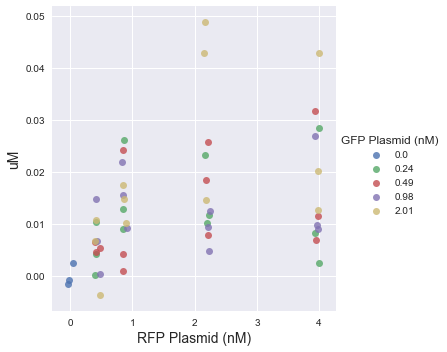

In [11]:
red_endpoints = endpoint_df[(endpoint_df.Channel == "RFP") & (endpoint_df.Gain == 100)]
sns.lmplot(data = red_endpoints, x = 'RFP Plasmid (nM)', 
              y = 'uM', hue = 'GFP Plasmid (nM)', fit_reg = False,
              x_jitter = 0.05)

### Averaging in other windows

You can also take time averages in other windows using the `window_averages` function. This works much like `endpoint_averages`, except that instead of averaging over a slice at the end of the experiment, it will average over a window whose start and end you specify. You can specify start and end times using seconds, hours, or a timepoint index. 

In [12]:
# Averaging over a window near the start of the experiment, 
# indexed by hours
endpoint_df = mt_biotek.window_averages(corrected_df, 2, 4, "hours")
endpoint_df.head()

,Channel,Gain,Well,index,Time (sec),Time (hr),AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate
0,GFP,61,A11,13850.5,10779,2.994167,74.666667,0.098440,488,488,0.44,0.24,2
1,GFP,61,A12,13851.5,10779,2.994167,184.516667,0.243265,488,488,0.44,0.49,2
2,GFP,61,A13,13852.5,10779,2.994167,54.966667,0.072468,488,488,0.44,0.98,2
3,GFP,61,A14,13853.5,10779,2.994167,-2.533333,-0.003340,488,488,0.44,2.01,2
4,GFP,61,A6,13846.5,10779,2.994167,61.016667,0.080444,488,488,0.44,0.24,1


In [13]:
# indexed by seconds
endpoint_df = mt_biotek.window_averages(corrected_df, 7200, 14400, 
                                        "seconds")
endpoint_df.head()

,Channel,Gain,Well,index,Time (sec),Time (hr),AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate
0,GFP,61,A11,13850.5,10779,2.994167,74.666667,0.098440,488,488,0.44,0.24,2
1,GFP,61,A12,13851.5,10779,2.994167,184.516667,0.243265,488,488,0.44,0.49,2
2,GFP,61,A13,13852.5,10779,2.994167,54.966667,0.072468,488,488,0.44,0.98,2
3,GFP,61,A14,13853.5,10779,2.994167,-2.533333,-0.003340,488,488,0.44,2.01,2
4,GFP,61,A6,13846.5,10779,2.994167,61.016667,0.080444,488,488,0.44,0.24,1


In [14]:
# indexed by index
endpoint_df = mt_biotek.window_averages(corrected_df, 33, 53, "index")
endpoint_df.head()

,Channel,Gain,Well,index,Time (sec),Time (hr),AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate
0,GFP,61,A11,14539,15639,4.344167,101.650794,0.134016,488,488,0.44,0.24,2
1,GFP,61,A12,14540,15639,4.344167,260.126984,0.342949,488,488,0.44,0.49,2
2,GFP,61,A13,14541,15639,4.344167,72.317460,0.095343,488,488,0.44,0.98,2
3,GFP,61,A14,14542,15639,4.344167,-1.920635,-0.002532,488,488,0.44,2.01,2
4,GFP,61,A6,14535,15639,4.344167,85.222222,0.112356,488,488,0.44,0.24,1


### Spline Fit

If you want to work with a denoised version of your data, you can fit a 3rd order spline to that data using the `spline_fit` function. `spline_fit` returns a dataframe identical to the original, except that it contains an extra column "uM spline fit", which contains the fit.

In [15]:
fit_df = mt_biotek.spline_fit(df)
fit_df.head()

/Users/sclamons/anaconda/lib/python3.6/site-packages/murraylab_tools/biotek/biotek.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[column + " spline fit"] = spline(group["Time (sec)"])


,Channel,Gain,Time (sec),Time (hr),Well,AFU,uM,Excitation,Emission,RFP Plasmid (nM),GFP Plasmid (nM),Replicate,uM spline fit
12346,GFP,61,159,0.044167,A11,0,0.000000,488,488,0.44,0.24,2,0.000364
12397,GFP,61,519,0.144167,A11,5,0.006592,488,488,0.44,0.24,2,0.004141
12448,GFP,61,879,0.244167,A11,0,0.000000,488,488,0.44,0.24,2,0.007910
12499,GFP,61,1239,0.344167,A11,2,0.002637,488,488,0.44,0.24,2,0.011672
12550,GFP,61,1599,0.444167,A11,15,0.019776,488,488,0.44,0.24,2,0.015424


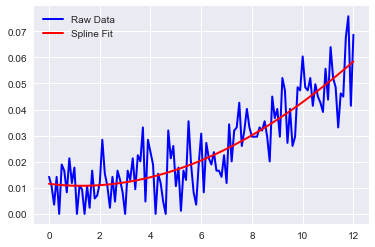

In [16]:
example_fit_df = fit_df[(fit_df.Gain == 100) & (fit_df.Channel == "RFP") \
                        & (fit_df["GFP Plasmid (nM)"] == 2.01) & (fit_df["RFP Plasmid (nM)"] == 3.97)\
                        & (fit_df.Replicate == 1)]
plt.plot(example_fit_df["Time (hr)"], example_fit_df["uM"], color = "blue", label = "Raw Data")
plt.plot(example_fit_df["Time (hr)"], example_fit_df["uM spline fit"], color = "red", label="Spline Fit")
plt.legend(loc = 2)

If you don't think your fit is great, you can fit more locally by shrinking the optional "smoothing_factor" argument, or more global by increasing the "smoothing_factor" argument. Here's an example of an over-fit spline:

/Users/sclamons/anaconda/lib/python3.6/site-packages/murraylab_tools/biotek/biotek.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[column + " spline fit"] = spline(group["Time (sec)"])


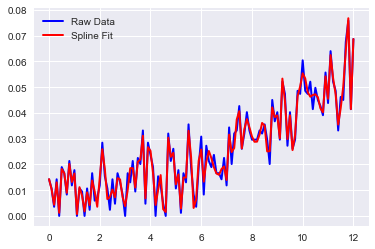

In [17]:
fit_df = mt_biotek.spline_fit(df, smoothing_factor = .001)
example_fit_df = fit_df[(fit_df.Gain == 100) & (fit_df.Channel == "RFP") \
                        & (fit_df["GFP Plasmid (nM)"] == 2.01) & (fit_df["RFP Plasmid (nM)"] == 3.97)\
                        & (fit_df.Replicate == 1)]
plt.plot(example_fit_df["Time (hr)"], example_fit_df["uM"], color = "blue", label = "Raw Data")
plt.plot(example_fit_df["Time (hr)"], example_fit_df["uM spline fit"], color = "red", label="Spline Fit")
plt.legend(loc = 2)

Let's look at some splined fits for the GFP data from above:

/Users/sclamons/anaconda/lib/python3.6/site-packages/murraylab_tools/biotek/biotek.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[column + " spline fit"] = spline(group["Time (sec)"])


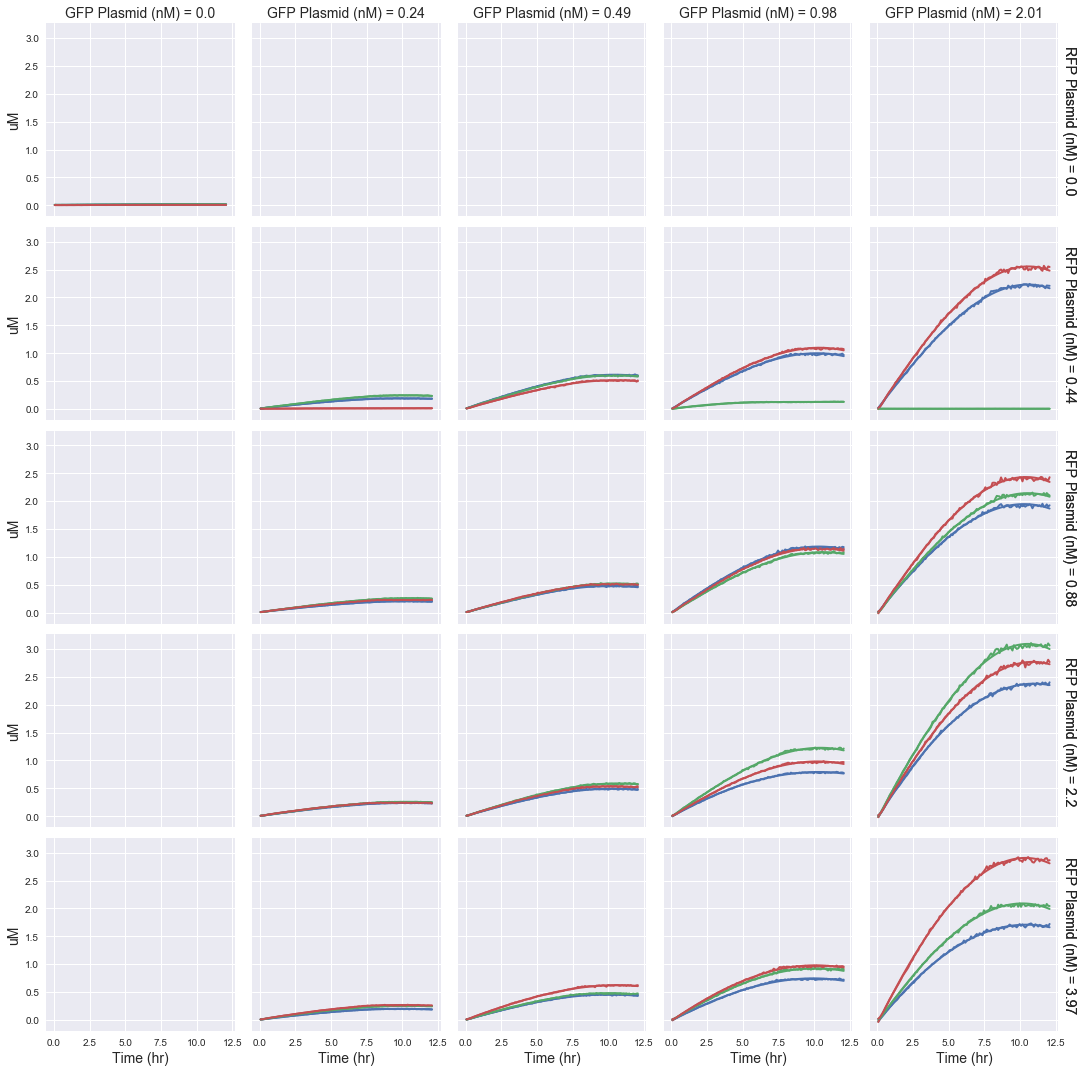

In [18]:
gfp_df = df[(df.Gain == 100) & (df.Channel == "GFP")]
splined_gfp_df = mt_biotek.spline_fit(gfp_df)
grid = sns.FacetGrid(splined_gfp_df, col = "GFP Plasmid (nM)", 
                     row = "RFP Plasmid (nM)", 
                     hue = "Replicate", margin_titles = True)
grid.map(plt.plot, "Time (hr)", "uM spline fit")
grid.map(plt.plot, "Time (hr)", "uM")
grid.fig.tight_layout(w_pad=1)
plt.show()

/Users/sclamons/anaconda/lib/python3.6/site-packages/murraylab_tools/biotek/biotek.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[column + " spline fit"] = spline(group["Time (sec)"])


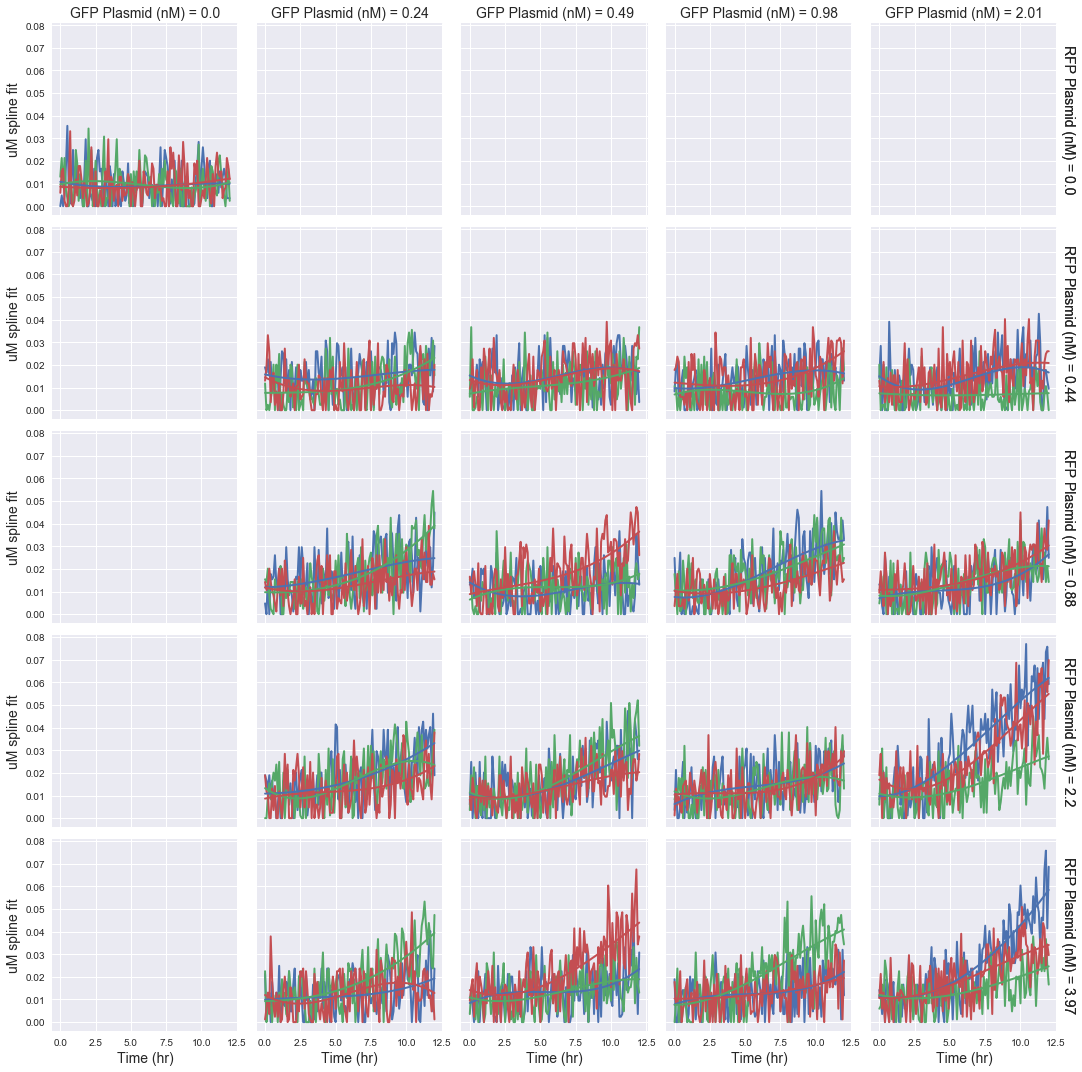

In [19]:
rfp_df = df[(df.Gain == 100) & (df.Channel == "RFP")]
splined_rfp_df = mt_biotek.spline_fit(rfp_df)
grid = sns.FacetGrid(splined_rfp_df, col = "GFP Plasmid (nM)", 
                     row = "RFP Plasmid (nM)", 
                     hue = "Replicate", margin_titles = True)
grid.map(plt.plot, "Time (hr)", "uM")
grid.map(plt.plot, "Time (hr)", "uM spline fit")
grid.fig.tight_layout(w_pad=1)
plt.show()

They're pretty good fits, though note the downward-turning tails on the ends of most of them. 

### Derivative calculation

You can calculate the rate of production of a molecule using the `smoothed_derivatives` function. This function first fits a spline, using the `spline_fit` function described above. It then numerically calculates the derivative of that spline, in units of uM/sec (or U/sec, whatever the actual unit in the "uM" column is).

Here is the GFP data from above plotted again as a time derivative:

/Users/sclamons/anaconda/lib/python3.6/site-packages/murraylab_tools/biotek/biotek.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[column + " spline fit"] = spline(group["Time (sec)"])
/Users/sclamons/anaconda/lib/python3.6/site-packages/murraylab_tools/biotek/biotek.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[column + "/sec"] = np.gradient(group[column + " spline fit"])


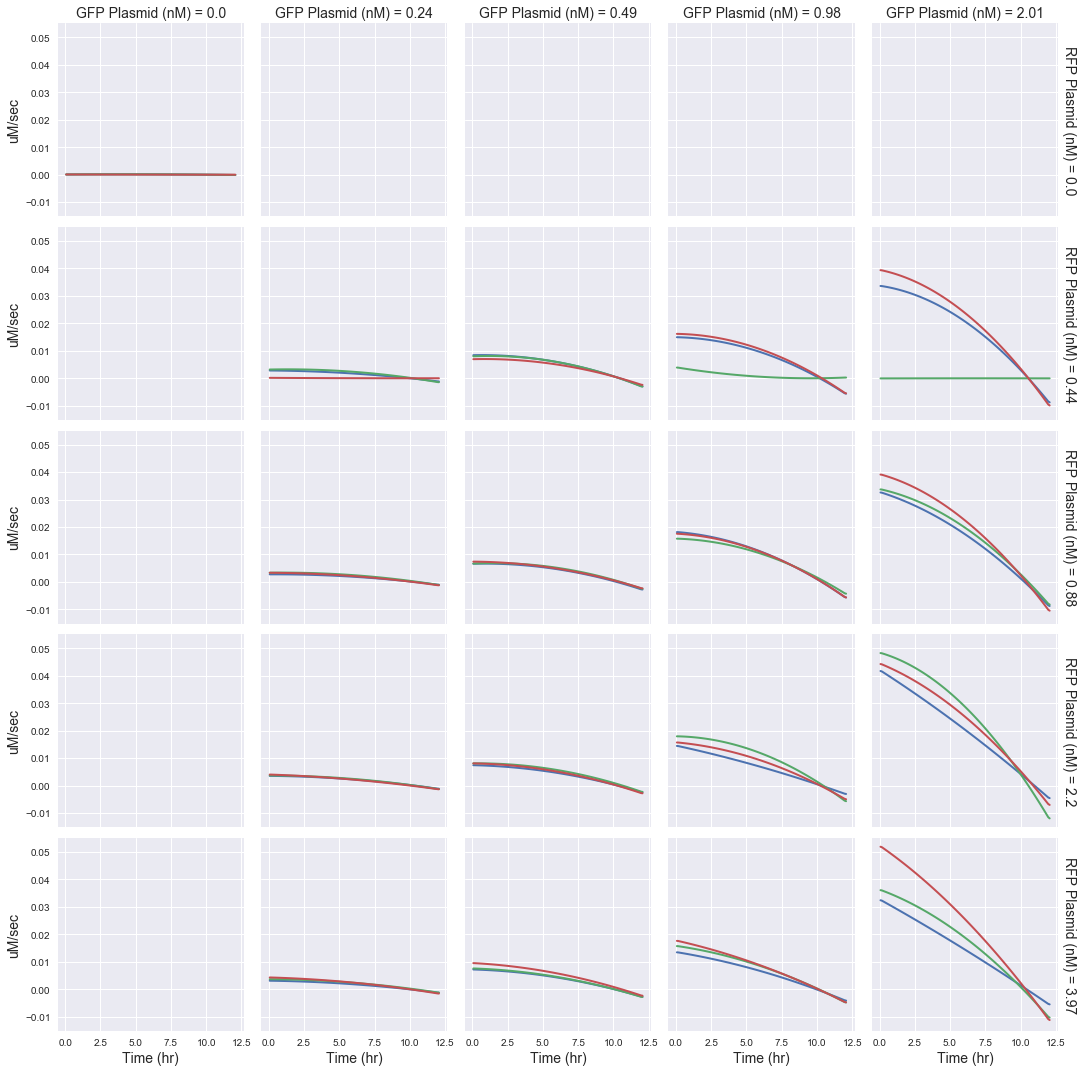

In [20]:
gfp_df = df[(df.Gain == 100) & (df.Channel == "GFP")]
deriv_df = mt_biotek.smoothed_derivatives(gfp_df)
grid = sns.FacetGrid(deriv_df, col = "GFP Plasmid (nM)", row = "RFP Plasmid (nM)", 
                     hue = "Replicate", margin_titles = True)
grid.map(plt.plot, "Time (hr)", "uM/sec")
grid.fig.tight_layout(w_pad=1)
plt.show()

### Manual Unit Conversion

If you want to manually convert an AFU readout to absolute concentration, you can do so with the `raw_to_uM` function of murraylab_tools.biotek. To convert, you will need the name of the fluorescent protein (one of "GFP", "Citrine", "RFP", "CFP", "Venus", or "Cherry"), the biotek number (one of "b1", "b2", or "b3"), the gain (61 or 100), and the reaction volume (any number, in µL).

In [21]:
AFU = 1000
channel = "GFP"
biotek = "b1"
gain = 61
volume = 5
mt_biotek.raw_to_uM(AFU, channel, biotek, gain, volume)

1.3183915622940012

# OD (or other) Normalization

Remember that cell data we briefly imported at the beginning of this tutorial? There was GFP flourescence data in there alongside the OD data. We often want to normalize fluorescence data by OD, so there's a function for that:

In [22]:
cell_df.head()

,Channel,Gain,Time (sec),Time (hr),Well,AFU,uM,Excitation,Emission,Row,Column
0,OD600,-1,145,0.040278,A1,0.091,0.091,600,-1,A,1
1,OD600,-1,145,0.040278,A2,0.107,0.107,600,-1,A,2
2,OD600,-1,145,0.040278,A3,0.120,0.120,600,-1,A,3
3,OD600,-1,145,0.040278,A4,0.127,0.127,600,-1,A,4
4,OD600,-1,145,0.040278,A5,0.110,0.110,600,-1,A,5


In [23]:
normalized_df = mt_biotek.normalize(cell_df)

#sns.tsplot(cell_df[cell_df.Row == "A"], time = "Time (hr)", value = "uM", unit = "Column")

AttributeError: module 'murraylab_tools.biotek' has no attribute 'normalize'

In [ ]:
help(mt_biotek.normalize)